<a href="https://colab.research.google.com/github/ksnugroho/teori-praktik-cv-part1/blob/main/Bagian_2_Bab_5_5_1_Batasan_Neural_Network_Tradisional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mengunduh Dataset

In [2]:
data_folder = './data/FMNIST'

train_data = datasets.FashionMNIST(data_folder, download=True, train=True)
val_data = datasets.FashionMNIST(data_folder, download=True, train=False)

tr_images, tr_targets = train_data.data, train_data.targets
val_images, val_targets = val_data.data, val_data.targets

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.91MB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 25.3MB/s]

Extracting ./data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



In [3]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1, 28*28)
        self.x, self.y = x, y

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)

# Melatih Model

In [4]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

# Tanpa hidden layer
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
        val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [5]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
    print(f"Epoch {epoch + 1}")
    train_epoch_losses, train_epoch_accuracies = [], []

    for x, y in trn_dl:
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for x, y in trn_dl:
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for x, y in val_dl:
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

Epoch 1
Train Loss: 0.4757, Train Accuracy: 0.8727
Validation Loss: 0.3979, Validation Accuracy: 0.8564
Epoch 2
Train Loss: 0.3585, Train Accuracy: 0.8820
Validation Loss: 0.3802, Validation Accuracy: 0.8598
Epoch 3
Train Loss: 0.3204, Train Accuracy: 0.8899
Validation Loss: 0.3648, Validation Accuracy: 0.8708
Epoch 4
Train Loss: 0.2966, Train Accuracy: 0.8984
Validation Loss: 0.3500, Validation Accuracy: 0.8761
Epoch 5
Train Loss: 0.2791, Train Accuracy: 0.8991
Validation Loss: 0.3555, Validation Accuracy: 0.8721


# Prediksi

Text(0.5, 1.0, 'Trouser')

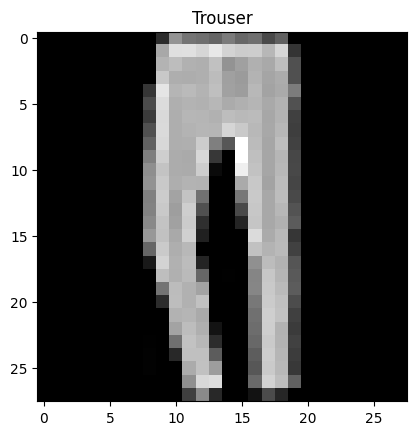

In [6]:
ix = 24500 # Pilih acak index gambar dari data pelatihan

plt.imshow(tr_images[ix], cmap='gray')
plt.title(train_data.classes[tr_targets[ix]])

In [7]:
img = tr_images[ix]/255.
img = img.view(28*28)
img = img.to(device)

In [8]:
np_output = model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))

array([5.3866319e-07, 9.9999911e-01, 1.5636649e-09, 2.6147006e-07,
       5.3731942e-08, 1.8909492e-14, 5.2185523e-09, 5.3436407e-17,
       2.2212959e-10, 2.1140818e-14], dtype=float32)

# Menerapkan Translasi pada Gambar

In [9]:
tr_targets[ix]

tensor(1)

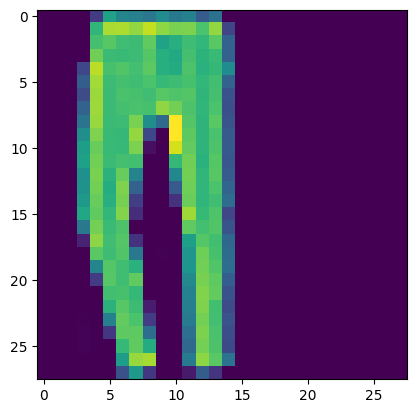

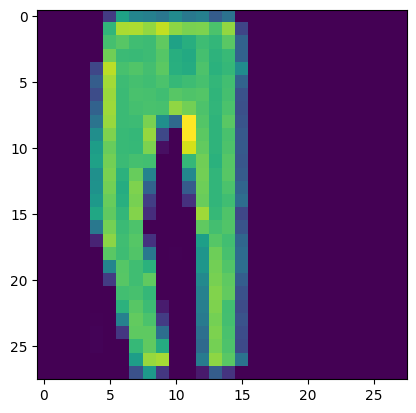

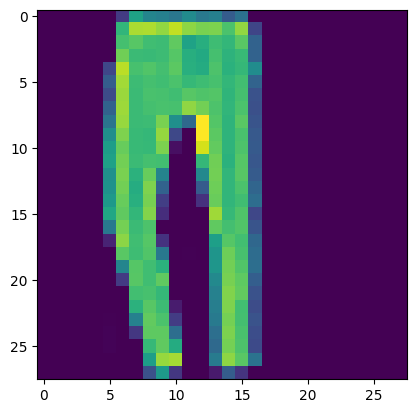

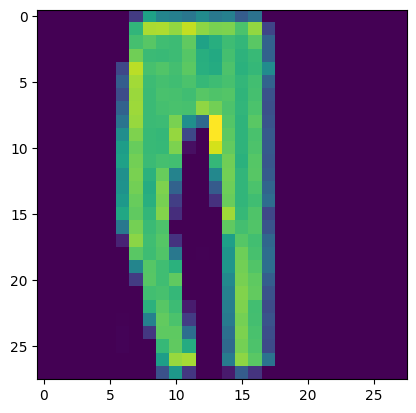

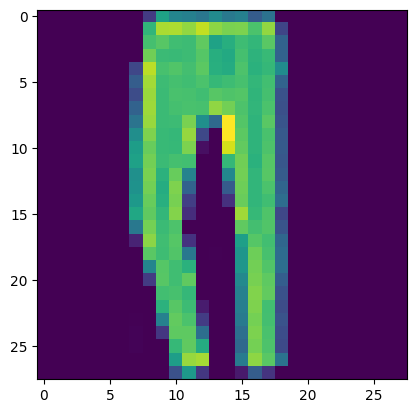

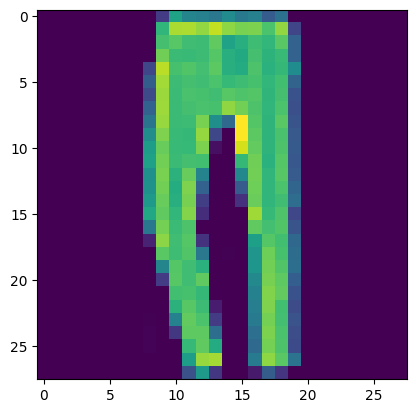

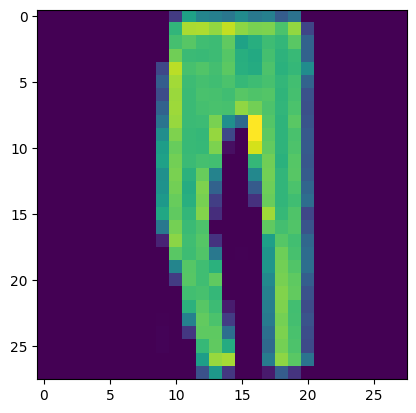

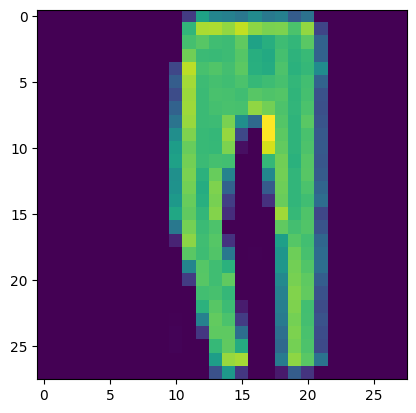

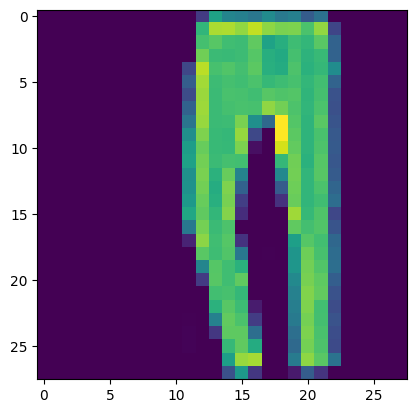

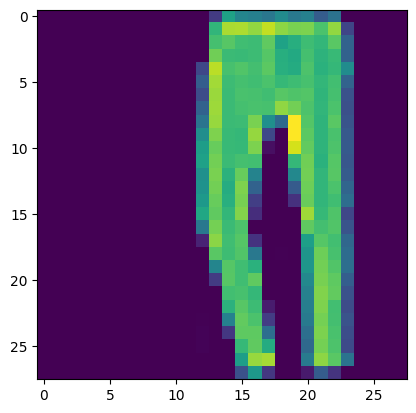

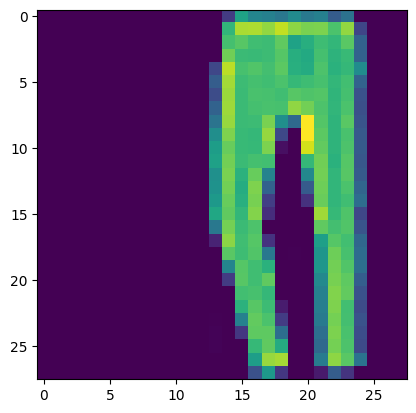

In [10]:
preds = []

for px in range(-5, 6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  plt.imshow(img2)
  plt.show()
  img3 = torch.Tensor(img2).view(28*28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

Text(0.5, 1.0, 'Probability of each class for various translations')

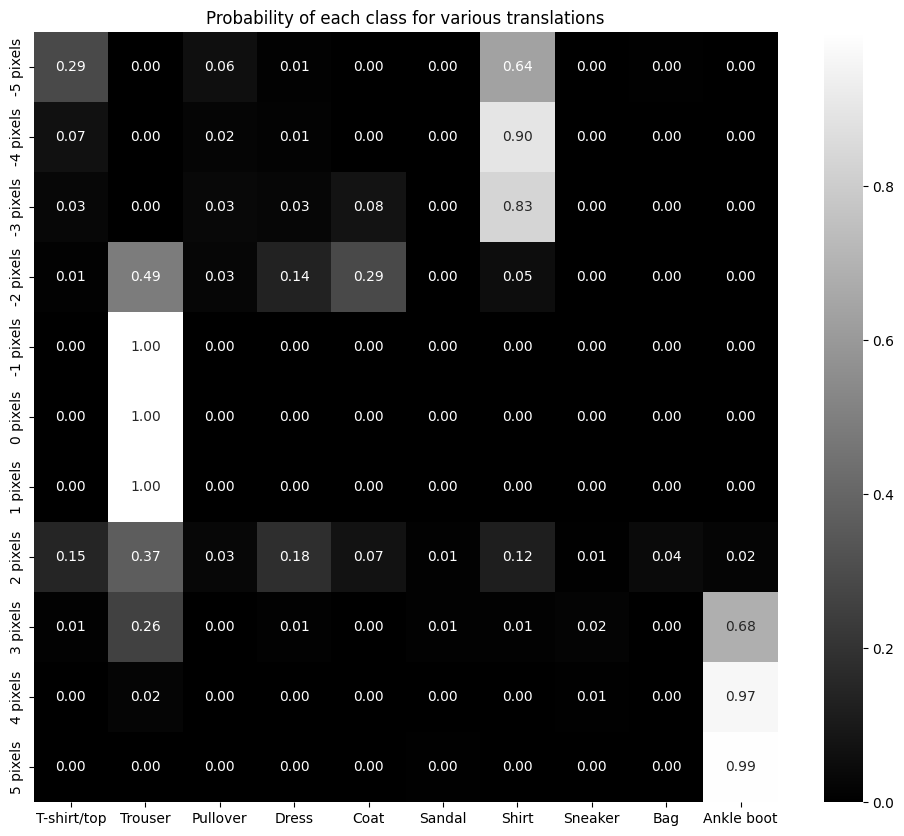

In [11]:
fig, ax = plt.subplots(1,1, figsize=(12,10))

sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=train_data.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')
plt.title('Probability of each class for various translations')